<h1>Importing Necessary Libraries</h1>

In [1]:
# Import necessary libraries for the rest of the project:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Fourier transforms and other signal processing techniques:
from scipy.fftpack import fft, fftfreq
from scipy.signal import hilbert

# For reading and pre-processing EDF files
import mne
from edf_annot_extract import read_edf_annotations, set_the_annotations, raw_to_df

# For detecting spindles via CWT using Morlet wavelets
from spindle_detect import spindle_detector

# For performing NLLS optimisation in the latter stage of the project
import lmfit

# For working with file names independent of the system type (Windows/Mac etc.)
from pathlib import Path, PureWindowsPath

# To quickly generate the QPS wavelet with user-assigned parameters.
from wavelet_generator import qps_time_sig

# Set seaborn as default template for matplotlib figures
sns.set()

# Instantiate a pandas dataframe for the final set of parameter values and labels for the dataset.
final_param_df = pd.DataFrame()

<h1>Requesting EDF File Names</h1>

In [2]:
# Request path that the EDF files are contained in:
print("Enter the file PATH that the files are located in:")
file_path = input()

Enter the file PATH that the files are located in:
C:\Users\Jason Ha\Documents\University\4th Year\Thesis Project (Repo)\Jupyter Notebooks\sleep_data


In [3]:
## print('Enter the file NAME for the PSG recording (in EDF format):')
file_psg_temp = input()

print('Enter the file NAME for the hypnogram associated with the PSG recording entered prior (in EDF format):')
file_hypnogram_temp = input()

file_psg = file_path + "\\" + file_psg_temp
file_hypnogram = file_path + '\\' + file_hypnogram_temp

SC4001E0-PSG.edf
Enter the file NAME for the hypnogram associated with the PSG recording entered prior (in EDF format):
SC4001EC-Hypnogram.edf


<h1>Reading The PSG and Hypnogram</h1>

In [4]:
# Reading the file name using MNE into a variable called 'raw'
raw = mne.io.read_raw_edf(file_psg, preload=True)

# Set the annotations on top of the raw PSG
set_the_annotations(file_hypnogram, raw)

Extracting EDF parameters from C:\Users\Jason Ha\Documents\University\4th Year\Thesis Project (Repo)\Jupyter Notebooks\sleep_data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


<ipython-input-4-6a097d5a8b18>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw = mne.io.read_raw_edf(file_psg, preload=True)


<Annotations  |  154 segments : sleep (154), orig_time : None>


C:\Users\Jason Ha\Documents\University\4th Year\Thesis Project (Repo)\Jupyter Notebooks\edf_annot_extract.py:59: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne_annot)


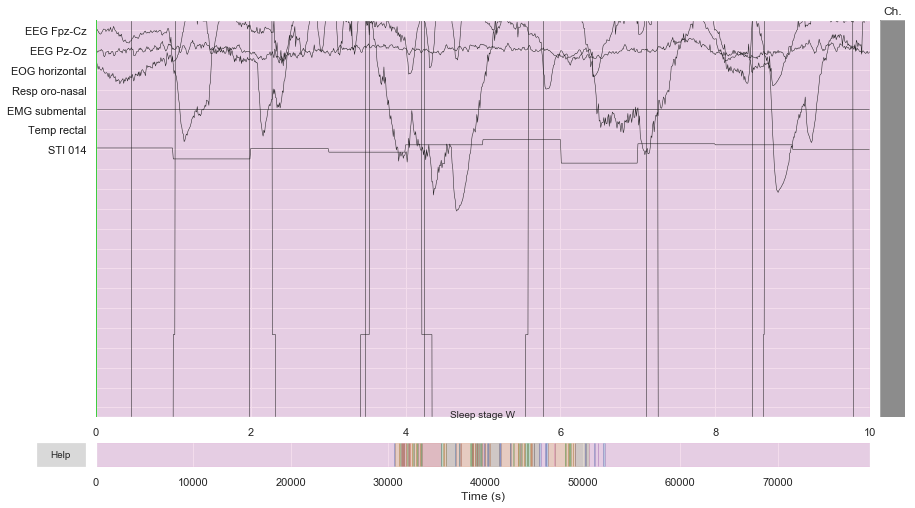

In [5]:
%matplotlib inline
raw.plot(block=True)
plt.show()

<h1>Converting Raw PSG Into Pandas Dataframe</h1>

In [6]:
(epochs, df) = raw_to_df(raw)

Used Annotations descriptions: ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage ?']
154 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 154 events and 1501 original time points ...
1 bad epochs dropped
Converting time column to int64...


In [7]:
#%matplotlib qt
#epochs.plot(block=True)
#plt.show()

In [8]:
df.head()

signal          condition  EEG Fpz-Cz  EEG Pz-Oz  EOG horizontal  \
epoch time                                                         
0     0     Sleep stage W    5.016850  -2.467399       16.508669   
      10    Sleep stage W   -2.578755   1.467399       16.015873   
      20    Sleep stage W    1.359707  -4.098901        9.609524   
      30    Sleep stage W   -2.391209  -2.659341        1.724786   
      40    Sleep stage W   -5.204396  -0.739927        7.638339   

signal      Resp oro-nasal  EMG submental   Temp rectal  STI 014  
epoch time                                                        
0     0       -482000000.0          3.552  3.720645e+07    920.0  
      10      -477000000.0          3.552  3.720538e+07    920.0  
      20      -472000000.0          3.554  3.720538e+07    920.0  
      30      -467000000.0          3.556  3.720538e+07    920.0  
      40      -462000000.0          3.558  3.720430e+07    920.0

In [9]:
df_N2 = df[df['condition'] == 'Sleep stage 2']
df_N2.head()

signal          condition  EEG Fpz-Cz  EEG Pz-Oz  EOG horizontal  \
epoch time                                                         
2     0     Sleep stage 2   20.676923   2.523077        2.217582   
      10    Sleep stage 2   18.238828   4.346520        6.159951   
      20    Sleep stage 2   20.208059  -1.987546        8.131136   
      30    Sleep stage 2   19.926740  -3.810989       11.580708   
      40    Sleep stage 2   18.332601  -5.250549       12.073504   

signal      Resp oro-nasal  EMG submental   Temp rectal  STI 014  
epoch time                                                        
2     0        333000000.0          2.464  3.686559e+07    826.0  
      10       339000000.0          2.464  3.686559e+07    826.0  
      20       344000000.0          2.466  3.686559e+07    826.0  
      30       350000000.0          2.466  3.686559e+07    826.0  
      40       355000000.0          2.468  3.686559e+07    826.0

In [10]:
eeg_columns = ['condition', 'EEG Fpz-Cz', 'EEG Pz-Oz']
df_N2_eeg = df_N2[eeg_columns].reset_index()
df_N2_eeg.head()

signal,epoch,time,condition,EEG Fpz-Cz,EEG Pz-Oz
0,2,0,Sleep stage 2,20.676923,2.523077
1,2,10,Sleep stage 2,18.238828,4.346520
2,2,20,Sleep stage 2,20.208059,-1.987546
3,2,30,Sleep stage 2,19.926740,-3.810989
4,2,40,Sleep stage 2,18.332601,-5.250549


<h1>Plotting An Epoch From The Dataframe</h1>

In [11]:
print('Epochs In Sleep Stage 2 Extract Of PSG: ') 
print(df_N2_eeg['epoch'].unique())

Epochs In Sleep Stage 2 Extract Of PSG: 
[  2   4  15  20  22  25  27  29  33  40  42  46  49  51  53  61  75  77
  79  81  83  87  89  91  93  95  97 101 103 110 113 123 126 128 130 132
 134 136 138 140]


In [12]:
print("Choose an epoch that you want to plot: ")
epoch_choice = input()
epoch_choice = int(epoch_choice)

Choose an epoch that you want to plot: 
22


In [13]:
print("Choose your desired EEG channel: ")
eeg_choice = input()

Choose your desired EEG channel: 
EEG Fpz-Cz


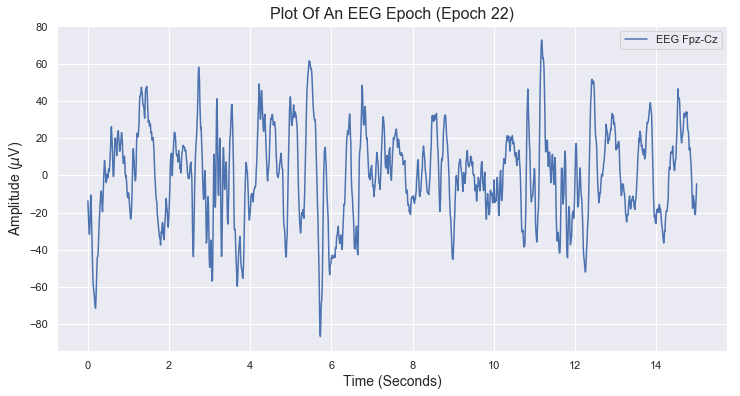

In [14]:
epoch_bool = (df_N2_eeg['epoch'] == epoch_choice)
t_epoch = df_N2_eeg[epoch_bool]['time'] /1e3
y_epoch = df_N2_eeg[epoch_bool][eeg_choice]

# Create a figure to plot the EEG epoch:
%matplotlib inline
fig = plt.figure(figsize=(12,6))

plt.title('Plot Of An EEG Epoch (Epoch 22)', fontsize=16)
plt.ylabel('Amplitude ($\mu$V)', fontsize=14)
plt.xlabel('Time (Seconds)', fontsize=14)
plt.plot(t_epoch, y_epoch)
plt.legend()

plt.savefig('epoch', dpi=300)

plt.show()

<h1>Spindle Detection via Wavelet Convolution (CWT)</h1>

In [15]:
# Request user for the wavelet frequency (wlt_freq), number of cycles in wavelet (n_cycles), the sampling frequency (sfreq)
# and the normalised power threshold:
print('Enter the desired Morlet wavelet frequency:')
wlt_freq = input()
wlt_freq = int(wlt_freq)

print('Enter the number of cycles in the Morlet wavelet:')
n_cycles = input()
n_cycles = int(n_cycles)

print('Enter the sampling frequency of the EEG epoch:')
sfreq = input()
sfreq = int(sfreq)

print('Enter the desired threshold normalised power (a number betwen 0.00 to 1.00):')
thresh_power = input()
thresh_power = float(thresh_power)

Enter the desired Morlet wavelet frequency:
13
Enter the number of cycles in the Morlet wavelet:
10
Enter the sampling frequency of the EEG epoch:
100
Enter the desired threshold normalised power (a number betwen 0.00 to 1.00):
0.25


In [16]:
(t_morlet, wlt, detected_spindles, norm_power) = spindle_detector(y_epoch, wlt_freq, n_cycles, sfreq, thresh_power)

Number of detected "detected" spindles (double check using the output power time-series graph):
1
Spindle onset and offset times:

[[288 346]]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


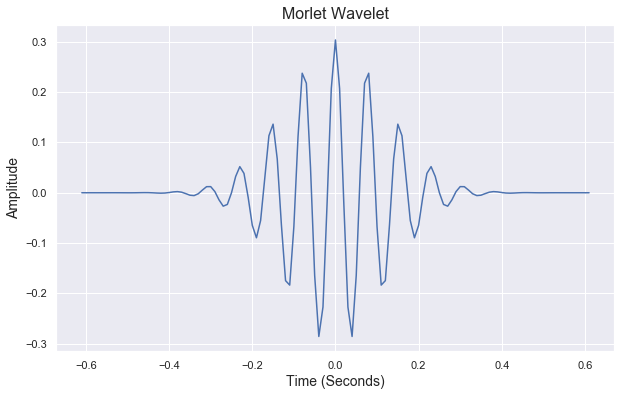

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(10,6))
plt.title('Morlet Wavelet', fontsize=16)
plt.xlabel('Time (Seconds)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.plot(t_morlet, wlt)
plt.savefig('mne_morlet', dpi=300)
plt.show()

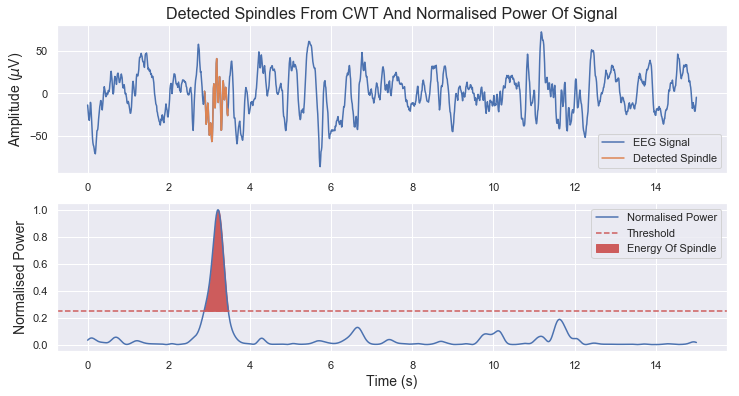

In [45]:
fig, (ax1, ax2)= plt.subplots(2,1,figsize=(12,6))

ax1.set_title('Detected Spindles From CWT And Normalised Power Of Signal', fontsize=16)

ax1.plot(t_epoch, y_epoch, label='EEG Signal')
ax1.plot(t_epoch, detected_spindles, label='Detected Spindle')
ax1.set_ylabel('Amplitude ($\mu$V)', fontsize=14)
ax1.legend()

ax2.plot(t_epoch, norm_power, label='Normalised Power')
ax2.axhline(0.25, linestyle='--', color='indianred', label='Threshold')
ax2.set_ylabel('Normalised Power', fontsize=14)
ax2.set_xlabel('Time (s)', fontsize=14)
ax2.fill_between(t_epoch, norm_power, thresh_power, where=norm_power>=thresh_power, color='indianred', label='Energy Of Spindle')
ax2.legend()

plt.savefig('spindle_detect', dpi=300)

plt.show()

<h1>Frequency Spectrum Of EEG Epoch Segment and Wavelet</h1>

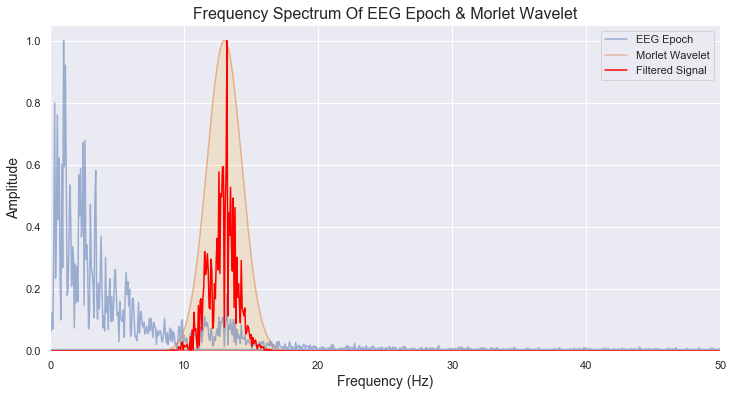

In [88]:
# Step 1: Perform Fourier transform on the EEG epoch segment
epoch_fft = abs(fft(y_epoch)) / (len(abs(fft(y_epoch))) / 2) # (Re-scaling amplitude of FFT based on sample length)
epoch_fft_norm = epoch_fft / max(epoch_fft) # (Normalising the amplitude from 0.0 to 1.0)
epoch_fft_xaxis = fftfreq(len(y_epoch), 1/sfreq)

# Step 2: Perform the Fourier transform on the Morlet wavelet
wlt_fft = abs(fft(wlt, n = epoch_fft.size))
# (Normalising the amplitude from 0 to 1)
wlt_fft_norm = wlt_fft / max(abs(fft(wlt, n = epoch_fft.size))) 
wlt_fft_xaxis = fftfreq(wlt_fft.size, 1/sfreq)

# Step 3: Point-wise multiplication between the two transformed signals:
mult_fft = np.multiply(epoch_fft_norm, wlt_fft_norm)
mult_fft_norm = mult_fft / max(mult_fft)

# Step 4: Plot the frequency spectrum for both signals:
fig = plt.figure(figsize=(12,6))

plt.title('Frequency Spectrum Of EEG Epoch & Morlet Wavelet', fontsize=16)
plt.ylabel('Amplitude', fontsize=14)
plt.xlabel('Frequency (Hz)', fontsize=14)

plt.plot(epoch_fft_xaxis, epoch_fft_norm, label='EEG Epoch',alpha=0.5)
plt.plot(wlt_fft_xaxis, wlt_fft_norm, label='Morlet Wavelet',alpha=0.5)
plt.plot(epoch_fft_xaxis, mult_fft_norm, label='Filtered Signal', color='red')

plt.fill_between(wlt_fft_xaxis, wlt_fft_norm, 0, where=wlt_fft >= 0, color='orange', alpha=0.15)

plt.xlim([0, max(epoch_fft_xaxis)])
plt.ylim([0, 1.05])

plt.legend()

plt.savefig('epoch_wlt_spectrum', dpi=300)

plt.show()

<h1>Extracting and Filtering The Detected Spindle</h1>

In [20]:
# Request spindle onset and offset indices from the user based on output from the spindle detection:
print('Enter the array index for ONE of the detected spindles ONSET:')
onset = input()
print('Enter the array index for ONE of the detected spindles OFFSET:')
offset = input()

onset = int(onset)
offset = int(offset)

Enter the array index for ONE of the detected spindles ONSET:
288
Enter the array index for ONE of the detected spindles OFFSET:
346


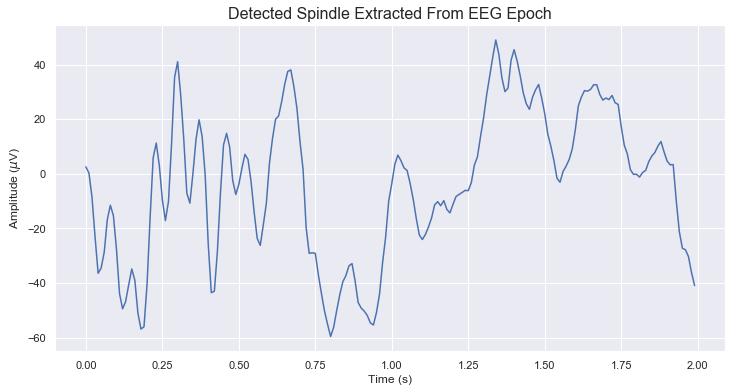

In [21]:
raw_spindle = y_epoch[onset:offset + 142]
raw_spindle_t = t_epoch[onset:offset + 142] 

fig = plt.figure(figsize=(12,6))
plt.title('Detected Spindle Extracted From EEG Epoch', fontsize=16)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude ($\mu$V)')
plt.plot(raw_spindle_t - min(raw_spindle_t), raw_spindle)
plt.savefig('extracted_spindle', dpi=300)
plt.show()

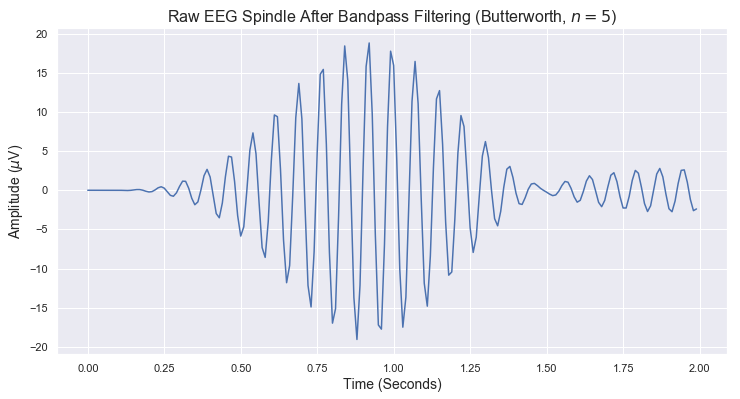

In [22]:
from bandpass_filter import butter_bandpass_filter

lowcut = 12
highcut = 14
sfreq = 100

filtered_spindle = butter_bandpass_filter(raw_spindle, lowcut, highcut, sfreq, order=5)

symm_time = raw_spindle_t - min(raw_spindle_t)

fig = plt.figure(figsize=(12,6))
plt.title('Raw EEG Spindle After Bandpass Filtering (Butterworth, $n=5$)', fontsize=16)
plt.ylabel('Amplitude ($\mu$V)', fontsize=14)
plt.xlabel('Time (Seconds)', fontsize=14)
plt.plot(symm_time, filtered_spindle)

plt.savefig('filtered_spindle', dpi=300)

plt.show()

<h1>Fitting QPS Wavelet Model To Filtered EEG Spindle</h1>

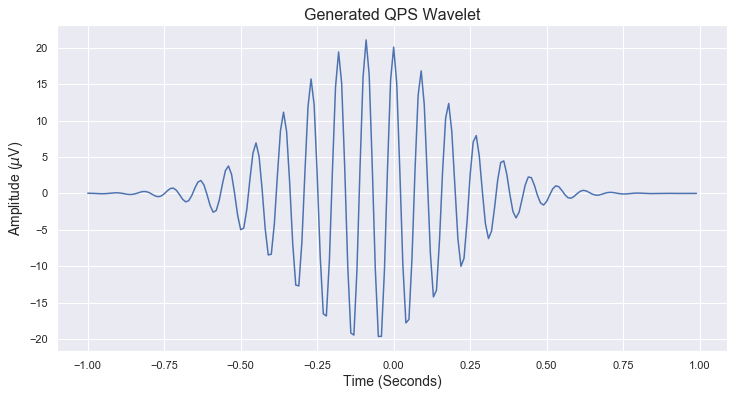

In [23]:
## from wavelet_generator import qps_time_sig

s_t = np.arange(-1,1, 1/sfreq)

s = qps_time_sig(s_t, a=3, b=-1.25, c=-8, d=0, e=70, f=1)

fig = plt.figure(figsize=(12,6))
plt.title('Generated QPS Wavelet', fontsize=16)
plt.xlabel('Time (Seconds)', fontsize=14)
plt.ylabel('Amplitude ($\mu$V)', fontsize=14)
plt.plot(s_t, s)

plt.savefig('qps', dpi=300)

plt.show()

In [24]:
from lmfit import Parameters, minimize

def residual(params, t, data):
    a, b, c = params['a'], params['b'], params['c']
    d, e, f = params['d'], params['e'], params['f']

    model = np.exp(a + b*t + c*t**2) * np.cos(d + e*t + f*t**2)
    chi = (data - model)
    
    return chi

# Set up an empty set of parameters:
# a=3, b=-1.25, c=-8, d=0, e=70, f=1
params = Parameters()
params.add('a', value=3)
params.add('b', value=-1.25)
params.add('c', value=-8)
params.add('d', value=0)
params.add('e', value=70)
params.add('f', value=1)
    
out = minimize(residual, params, args=(s_t, filtered_spindle))

In [25]:
out

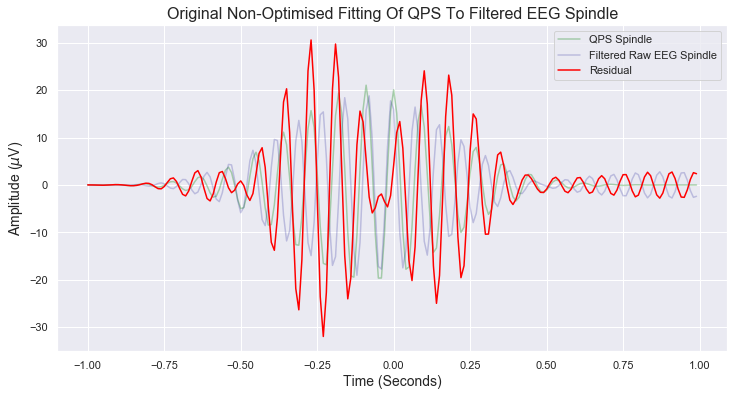

In [26]:
fig = plt.figure(figsize=(12,6))
plt.title('Original Non-Optimised Fitting Of QPS To Filtered EEG Spindle', fontsize=16)
plt.ylabel('Amplitude ($\mu$V)', fontsize=14)
plt.xlabel('Time (Seconds)', fontsize=14)
plt.plot(s_t, s, color='green', alpha=0.3, label='QPS Spindle')
plt.plot(s_t, filtered_spindle, color='darkblue', alpha=0.2, label='Filtered Raw EEG Spindle')
plt.plot(s_t, s - filtered_spindle, color='red', alpha=1.0, label='Residual')
plt.legend()

plt.savefig('nonoptimal', dpi=300)

plt.show()

In [27]:
dict_params = {'a':0, 'b':0, 'c':0, 'd':0, 'e':0, 'f':0}
list_params = ['a','b','c','d', 'e', 'f']

for parameter in list_params:
    dict_params[parameter] = out.params[parameter].value

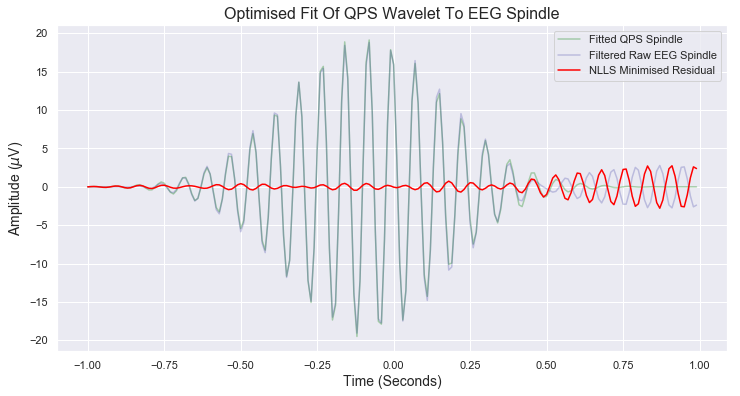

In [28]:
s_fit = qps_time_sig(s_t, a=dict_params['a'], b=dict_params['b'], c=dict_params['c'], d=dict_params['d'], e=dict_params['e'], f=dict_params['f'])

fig = plt.figure(figsize=(12,6))
plt.title('Optimised Fit Of QPS Wavelet To EEG Spindle', fontsize=16)
plt.xlabel('Time (Seconds)', fontsize=14)
plt.ylabel('Amplitude ($\mu$V)', fontsize=14)

plt.plot(s_t, s_fit, color='green', alpha=0.3, label='Fitted QPS Spindle')
plt.plot(s_t, filtered_spindle, color='darkblue', alpha=0.2, label='Filtered Raw EEG Spindle')
plt.plot(s_t, s_fit - filtered_spindle, color='red', alpha=1.0, label='NLLS Minimised Residual')

plt.legend()

plt.savefig('optimised', dpi=300)

plt.show()

In [29]:
print('Optimised QPS Parameter Values AFTER NLLS (Levenberg-Marquadt) Algorithm: ')
dict_params

Optimised QPS Parameter Values AFTER NLLS (Levenberg-Marquadt) Algorithm: 


{'a': 2.913888134694795,
 'b': -1.4099820110641925,
 'c': -7.675173191825602,
 'd': 0.528809149057398,
 'e': 82.18792939971459,
 'f': -1.5794808180230266}

In [30]:
# Copy dictionary to a temporary dictionary:
temp_dict = dict_params

In [31]:
# Ask user if the the QPS was fitted to a spindle (S) or non-spindle (NS)
print("Does the fitted QPS wavelet correspond to a spindle (S) or non-spindle (NS). Enter S or NS in the input")
label = input()

Does the fitted QPS wavelet correspond to a spindle (S) or non-spindle (NS). Enter S or NS in the input
S


In [32]:
# Ask user the duration of the sampled EEG sample
print('What was the duration of the spindle (in seconds)')
duration = input()

What was the duration of the spindle (in seconds)
1.25


In [33]:
# Add new key:value to the param_dict in the form "label:'S'" or "label:'NS'"
dict_params['label'] = label
dict_params['duration_seconds'] = duration

In [34]:
# Parameters are about to be added to a Dataframe. Request the current index for the dataframe (an integer value)
print('What is the current index for the final dataframe?')
index = input()
i = int(index)

What is the current index for the final dataframe?
0


In [35]:
# Create a new Pandas dataframe for the parameters as column names. Assume an empty dataframe first
param_df = pd.DataFrame(temp_dict, index=[i])

In [36]:
param_df

,a,b,c,d,e,f,label,duration_seconds
0,2.913888,-1.409982,-7.675173,0.528809,82.187929,-1.579481,S,1.25


In [37]:
with open('spindle_physionet.csv', 'a') as f:
    param_df.to_csv(f, header=False)